In [1]:
from __future__ import print_function
import numpy as np
import scipy
import json
np.random.seed(244)  # for reproducibility
import keras
#print(keras.__version__)
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten,Reshape,Activation,ActivityRegularization
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import backend as K # We are using TensorFlow as Keras backend
# from keras import optimizers
from keras.utils import np_utils
import tensorflow as tf
print (tf.__version__)
from keras.utils import multi_gpu_model
#for AUC and ROC Curves
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
#import pickle
#import gzip
import sys
import os
#import matplotlib.image as mpimg
#import matplotlib as mpl
#from mpl_toolkits.mplot3d import Axes3D

#import h5py
from sklearn.metrics import log_loss

import time
start_time = time.time()

config = tf.compat.v1.ConfigProto()
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
config.gpu_options.per_process_gpu_memory_fraction = 0.7

#import data_loader as dl

#np.set_printoptions(threshold=np.nan) #error

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc, roc_auc_score
import scipy
#import scipy.ndimage
from scipy import ndimage
from scipy import stats
from scipy.signal import resample
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook



2.2.0


In [2]:
my_batch_size = 1028
valbatchsize = 1028

npoints = 40  #npoint=(Number of pixels+1) of the image
N_pixels=np.power(npoints,2)

# input image dimensions
img_rows, img_cols = npoints,npoints
ncolors=1
extra_label='ncolors1'

In [3]:

def expand_array(images):
# ARRAY MUST BE IN THE FORM [[[iimage,ipixel,jpixel],val],...]
    Nimages=len(images)
    print("in expand_array function")
    print('Number of images ',Nimages)
    expandedimages=np.zeros((Nimages,img_rows,img_cols,ncolors))
    for i in range(Nimages):
        for j in range(len(images[i])):
            expandedimages[i,images[i][j][0][0],images[i][j][0][1]] = images[i][j][1][0]+images[i][j][1][1]
    return expandedimages

In [4]:
def encoder(input_img,latent_dim,nf_dense):
    layer=input_img
    layer=Conv2D(128,kernel_size=(3,3),activation='relu',padding='same')(layer)
    layer=MaxPooling2D(pool_size=(2,2),padding='same')(layer)
    layer=Conv2D(128,kernel_size=(3,3),activation='relu',padding='same')(layer)
    layer=MaxPooling2D(pool_size=(2,2),padding='same')(layer)
    layer=Conv2D(128,kernel_size=(3,3),activation='relu',padding='same')(layer)
    layer=Flatten()(layer)
    layer=Dense(nf_dense, activation='relu')(layer)
    encoded=Dense(latent_dim)(layer)
    model = Model(inputs=input_img, outputs=encoded)
    model.summary()
    return model

input_shape_use = (npoints, npoints,ncolors)
input_img=Input(shape=input_shape_use)

latent_dim=6
nf_dense=32

encodedmodel=encoder(input_img,latent_dim,nf_dense)

def decoder(input_img,nf_dense):
	layer=encodedmodel(input_img)
	layer=Dense(nf_dense, activation='relu')(layer)
	layer=Dense(12800, activation='relu')(layer)
	layer=Reshape((10,10,128))(layer)
	layer=Conv2D(128, kernel_size=(3, 3),activation='relu',padding='same')(layer)
	layer=UpSampling2D((2,2))(layer)
	layer=Conv2D(128, kernel_size=(3, 3),activation='relu',padding='same')(layer)
	layer=UpSampling2D((2,2))(layer)
	layer=Conv2D(1, kernel_size=(3, 3),padding='same')(layer)
	layer=Reshape((1,1600))(layer)
	layer=Activation('softmax')(layer)
	decoded=Reshape((40,40,1))(layer)
	model = Model(inputs=input_img, outputs=decoded)
	model.summary()
	return model




Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 40, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       147584    
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0     

In [5]:
def binary_cross_entropy(trueimage,predimage):
    return -np.sum(trueimage*np.log(predimage+1e-7)+(1-trueimage)*np.log(1-predimage+1e-7),axis=(1,2,3))

def mean_squared_error(trueimage,predimage):
    return np.sum((trueimage-predimage)**2,axis=(1,2,3))

In [6]:
# Get the validation losses after each epoch
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = [1,1] #Initial value of the val loss function

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss')) # We append the val loss of the last epoch to losses

def step_decay(losses):

    if len(history.losses)>=2 and float(np.array(history.losses[-2])-np.array(history.losses[-1]))<0.0005:
        lrate=learning_rate[-1]/np.sqrt(2)
        learning_rate.append(lrate)
    else:
        lrate=learning_rate[-1]

    if len(history.losses)>=2:
        print('\n loss[-2] = ',np.array(history.losses[-2]))
        print('\n loss[-1] = ',np.array(history.losses[-1]))
        print('\n loss[-2] - loss[-1] = ',float(np.array(history.losses[-2])-np.array(history.losses[-1])))

    print('\n Learning rate =',lrate)
    print('------------'*10)
    
    return lrate

history=LossHistory()
lrate=keras.callbacks.LearningRateScheduler(step_decay) # Get new learning rate

early_stop=keras.callbacks.EarlyStopping(monitor='loss', min_delta=3*1e-9, patience=250, verbose=0, mode='auto')


In [7]:
twodcnn_large_dir = 'AE_weights/2dcnn'                                                                                                         
os.system("mkdir -p "+twodcnn_large_dir)

checkpoint=keras.callbacks.ModelCheckpoint("AE_weights/2dcnn/weights-{epoch:02d}.hdf5", monitor='loss', verbose=1,
                                           save_best_only=False, save_weights_only=True, mode='auto', period=1)



In [8]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [9]:
class TestCallback(keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
    def on_epoch_end(self, epoch, logs={}):
#        if((epoch+1) % 5 == 0):
        if True:
            bg, sigTOP, sigGLU, m_bg, m_TOP, m_GLU = self.test_data
            TOPmask_bg=(m_bg>175-50) & (m_bg<175+50)
            TOPmask_sig=(m_TOP>175-50) & (m_TOP<175+50)
            GLUmask_bg=(m_bg>400-50) & (m_bg<400+50)
            GLUmask_sig=(m_GLU>400-50) & (m_GLU<400+50)
            outbg=self.model.predict(bg, batch_size=5000,verbose=1)
            outsigGLU=self.model.predict(sigGLU, batch_size=5000,verbose=1)
            outsigTOP=self.model.predict(sigTOP, batch_size=5000,verbose=1)
            lossbg=mean_squared_error(bg,outbg)
            losssigGLU=mean_squared_error(sigGLU,outsigGLU)
            losssigTOP=mean_squared_error(sigTOP,outsigTOP)
            labels_all=np.concatenate((np.ones(len(losssigGLU)),np.zeros(len(lossbg))))
            dist_all=np.concatenate((losssigGLU,lossbg))
            fprGLU,tprGLU,thresholds=roc_curve(labels_all,dist_all)
            sicGLU=tprGLU/np.sqrt(fprGLU)
            sicGLU=sicGLU[np.isfinite(sicGLU)]
            labels_all=np.concatenate((np.ones(len(losssigTOP)),np.zeros(len(lossbg))))
            dist_all=np.concatenate((losssigTOP,lossbg))
            fprTOP,tprTOP,thresholds=roc_curve(labels_all,dist_all)
            sicTOP=tprTOP/np.sqrt(fprTOP)
            sicTOP=sicTOP[np.isfinite(sicTOP)]
            labels_all=np.concatenate((np.ones(len(losssigGLU[GLUmask_sig])),np.zeros(len(lossbg[GLUmask_bg]))))
            dist_all=np.concatenate((losssigGLU[GLUmask_sig],lossbg[GLUmask_bg]))
            fprGLU_m,tprGLU_m,thresholds=roc_curve(labels_all,dist_all)
            sicGLU_m=tprGLU_m/np.sqrt(fprGLU_m)
            sicGLU_m=sicGLU_m[np.isfinite(sicGLU_m)]
            labels_all=np.concatenate((np.ones(len(losssigTOP[TOPmask_sig])),np.zeros(len(lossbg[TOPmask_bg]))))
            dist_all=np.concatenate((losssigTOP[TOPmask_sig],lossbg[TOPmask_bg]))
            fprTOP_m,tprTOP_m,thresholds=roc_curve(labels_all,dist_all)
            sicTOP_m=tprTOP_m/np.sqrt(fprTOP_m)
            sicTOP_m=sicTOP_m[np.isfinite(sicTOP_m)]
            
            TOPeff = tprTOP[find_nearest(fprTOP,0.01)]
            GLUeff = tprGLU[find_nearest(fprGLU,0.01)]
            TOPeff_m = tprTOP[find_nearest(fprTOP_m,0.01)]
            GLUeff_m = tprGLU_m[find_nearest(fprGLU_m,0.01)]
            
            print('maxsic (for MSE) TOP,GLU,TOP(m),GLU(m): ',max(sicTOP),max(sicGLU),max(sicTOP_m),max(sicGLU_m))
            print('SigEff @ 1% BgEff (for MSE) TOP,GLU,TOP(m),GLU(m): ',TOPeff,GLUeff,TOPeff_m,GLUeff_m)
            sd.append([max(sicTOP),max(sicGLU),max(sicTOP_m),max(sicGLU_m),TOPeff,GLUeff,TOPeff_m,GLUeff_m,epoch+1])

            plt.plot(np.array(sd).T[8], np.array(sd).T[0],label="TOP MSE")
            plt.plot(np.array(sd).T[8], np.array(sd).T[1],label="GLU MSE")
            plt.plot(np.array(sd).T[8], np.array(sd).T[2],label="TOP_mw MSE")
            plt.plot(np.array(sd).T[8], np.array(sd).T[3],label="GLU_mw MSE")
            plt.xlabel("Epoch Number")
            plt.ylabel("Max SIC")
            plt.title("Trained on QCD, Latent Dimension 6")
            plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            plt.show()
            
            plt.plot(np.array(sd).T[8], np.array(sd).T[4],label="TOP MSE")
            plt.plot(np.array(sd).T[8], np.array(sd).T[5],label="GLU MSE")
            plt.plot(np.array(sd).T[8], np.array(sd).T[6],label="TOP_mw MSE")
            plt.plot(np.array(sd).T[8], np.array(sd).T[7],label="GLU_mw MSE")
            plt.xlabel("Epoch Number")
            plt.ylabel("SigEff @ 1% BgEff")
            plt.title("Trained on QCD, Latent Dimension 6")
            plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            plt.show()
            
            encodedtrain=encodedmodel.predict(trainimages, batch_size=128, verbose=0)
            encodedbg=encodedmodel.predict(testimagesbg, batch_size=128, verbose=0)
            encodedsigGLU=encodedmodel.predict(testimagessigGLU, batch_size=128,verbose=0)
            encodedsigTOP=encodedmodel.predict(testimagessigTOP, batch_size=128,verbose=0)

            databTR = np.array(encodedtrain)
            databTRT = databTR.T
            print("Training Sample: "+str(len(databTR)))
            print("Transpose: "+str(len(databTRT)))
            print ("Training kde")
            kde = stats.gaussian_kde(databTRT)
            print("Done")
            dataQCD = np.array(encodedbg)
            print("N_QCD = ", len(dataQCD))
            dataQCDT = dataQCD.T
            print("Transpose: "+str(len(dataQCDT)))
            print ("Evaluating kde on QCD...")
            try:
                QCD_pdf=kde.pdf(dataQCDT)
                print("Done")
                dataGLU = np.array(encodedsigGLU)
                print("N_GLU = ", len(dataGLU))
                dataGLUT = dataGLU.T
                print("Transpose: "+str(len(dataGLUT)))
                print ("Evaluating kde on GLU...")
                GLU_pdf=kde.pdf(dataGLUT)
                print ("Done")
                dataTOP = np.array(encodedsigTOP)
                print("N_TOP = ", len(dataTOP))
                dataTOPT = dataTOP.T
                print("Transpose: "+str(len(dataTOPT)))
                print ("Evaluating kde on TOP...")
                TOP_pdf=kde.pdf(dataTOPT)
                print ("Done")
            except:
                print("Failed to evaluate KDE for epoch: ",epoch+1)
                return
            
            minqcd = min(QCD_pdf)
            maxqcd = max(QCD_pdf)
            minglu = min(GLU_pdf)
            maxglu = max(GLU_pdf)
            mintop = min(TOP_pdf)
            maxtop = max(TOP_pdf)
            normal = max(maxqcd, maxglu, maxtop)
            QCD_pdf /= normal
            GLU_pdf /= normal
            TOP_pdf /= normal
            log10QCD_pdf = np.log10(QCD_pdf)
            log10GLU_pdf = np.log10(GLU_pdf)
            log10TOP_pdf = np.log10(TOP_pdf)
            log10QCD_pdf[np.isneginf(log10QCD_pdf)]=-10000
            log10GLU_pdf[np.isneginf(log10GLU_pdf)]=-10000
            log10TOP_pdf[np.isneginf(log10TOP_pdf)]=-10000
            mvQCD = min(i for i in log10QCD_pdf if i > -10000)
            mvGLU = min(i for i in log10GLU_pdf if i > -10000)
            mvTOP = min(i for i in log10TOP_pdf if i > -10000)
            mv = min(mvQCD, mvGLU, mvTOP)
            log10QCD_pdf[log10QCD_pdf == -10000] = mv
            log10GLU_pdf[log10GLU_pdf == -10000] = mv
            log10TOP_pdf[log10TOP_pdf == -10000] = mv
            
                        
            plt.hist(log10QCD_pdf,histtype="step",label="QCD",bins=100)
            plt.hist(log10GLU_pdf,histtype="step",label="GLU",bins=100)
            plt.hist(log10TOP_pdf,histtype="step",label="TOP",bins=100)
            plt.yscale('log')
            plt.xlabel("log10(PDF)")
            plt.legend(loc='upper left')
            plt.title("Trained on QCD, KDE PDF During Training, Latent Dimension 6")
            plt.show()
            
            plt.hist(log10QCD_pdf[GLUmask_bg],histtype="step",label="QCD",bins=100)
            plt.hist(log10GLU_pdf[GLUmask_sig],histtype="step",label="GLU",bins=100)
            plt.yscale('log')
            plt.xlabel("log10(PDF)")
            plt.legend(loc='upper left')
            plt.title("Trained on QCD, KDE PDF During Training, Mass Window GLU, Latent Dimension 6")
            plt.show()
            
            plt.hist(log10QCD_pdf[TOPmask_bg],histtype="step",label="QCD",bins=100)
            plt.hist(log10TOP_pdf[TOPmask_sig],histtype="step",label="TOP",bins=100)
            plt.yscale('log')
            plt.xlabel("log10(PDF)")
            plt.legend(loc='upper left')
            plt.title("Trained on QCD, KDE PDF During Training, Mass Window TOP, Latent Dimension 6")
            plt.show()
            
            log10QCD_pdf = log10QCD_pdf[~np.isnan(log10QCD_pdf)]
            log10GLU_pdf = log10GLU_pdf[~np.isnan(log10GLU_pdf)]
            log10TOP_pdf = log10TOP_pdf[~np.isnan(log10TOP_pdf)]
            
            labels_all=np.concatenate((np.ones(len(log10GLU_pdf)),np.zeros(len(log10QCD_pdf))))
            dist_all=np.concatenate((-log10GLU_pdf,-log10QCD_pdf))
            fprGLU,tprGLU,thresholds=roc_curve(labels_all,dist_all)
            sicGLU=tprGLU/np.sqrt(fprGLU)
            sicGLU=sicGLU[np.isfinite(sicGLU)]
            
            labels_all=np.concatenate((np.ones(len(log10TOP_pdf)),np.zeros(len(log10QCD_pdf))))
            dist_all=np.concatenate((-log10TOP_pdf,-log10QCD_pdf))
            fprTOP,tprTOP,thresholds=roc_curve(labels_all,dist_all)
            sicTOP=tprTOP/np.sqrt(fprTOP)
            sicTOP=sicTOP[np.isfinite(sicTOP)]
            
            labels_all=np.concatenate((np.ones(len(log10GLU_pdf[GLUmask_sig])),np.zeros(len(log10QCD_pdf[GLUmask_bg]))))
            dist_all=np.concatenate((-log10GLU_pdf[GLUmask_sig],-log10QCD_pdf[GLUmask_bg]))
            fprGLU_m,tprGLU_m,thresholds=roc_curve(labels_all,dist_all)
            sicGLU_m=tprGLU_m/np.sqrt(fprGLU_m)
            sicGLU_m=sicGLU_m[np.isfinite(sicGLU_m)]
            
            labels_all=np.concatenate((np.ones(len(log10TOP_pdf[TOPmask_sig])),np.zeros(len(log10QCD_pdf[TOPmask_bg]))))
            dist_all=np.concatenate((-log10TOP_pdf[TOPmask_sig],-log10QCD_pdf[TOPmask_bg]))
            fprTOP_m,tprTOP_m,thresholds=roc_curve(labels_all,dist_all)
            sicTOP_m=tprTOP_m/np.sqrt(fprTOP_m)
            sicTOP_m=sicTOP_m[np.isfinite(sicTOP_m)]
            
            TOPeff = tprTOP[find_nearest(fprTOP,0.01)]
            GLUeff = tprGLU[find_nearest(fprGLU,0.01)]
            TOPeff_m = tprTOP[find_nearest(fprTOP_m,0.01)]
            GLUeff_m = tprGLU_m[find_nearest(fprGLU_m,0.01)]
            
            print('maxsic (for PDF) TOP,GLU,TOP(m),GLU(m): ',max(sicTOP),max(sicGLU),max(sicTOP_m),max(sicGLU_m))
            print('SigEff @ 1% BgEff (for PDF) TOP,GLU,TOP(m),GLU(m): ',TOPeff,GLUeff,TOPeff_m,GLUeff_m)
            sdPDF.append([max(sicTOP),max(sicGLU),max(sicTOP_m),max(sicGLU_m),TOPeff,GLUeff,TOPeff_m,GLUeff_m,epoch+1])
            
            plt.plot(np.array(sdPDF).T[8], np.array(sdPDF).T[0],label="TOP PDF")
            plt.plot(np.array(sdPDF).T[8], np.array(sdPDF).T[1],label="GLU PDF")
            plt.plot(np.array(sdPDF).T[8], np.array(sdPDF).T[2],label="TOP_mw PDF")
            plt.plot(np.array(sdPDF).T[8], np.array(sdPDF).T[3],label="GLU_mw PDF")
            plt.xlabel("Epoch Number")
            plt.ylabel("Max SIC")
            plt.title("Trained on QCD, Latent Dimension 6")
            plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            plt.show()
            
            plt.plot(np.array(sdPDF).T[8], np.array(sdPDF).T[4],label="TOP PDF")
            plt.plot(np.array(sdPDF).T[8], np.array(sdPDF).T[5],label="GLU PDF")
            plt.plot(np.array(sdPDF).T[8], np.array(sdPDF).T[6],label="TOP_mw PDF")
            plt.plot(np.array(sdPDF).T[8], np.array(sdPDF).T[7],label="GLU_mw PDF")
            plt.xlabel("Epoch Number")
            plt.ylabel("SigEff @ 1% BgEff")
            plt.title("Trained on QCD, Latent Dimension 6")
            plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            plt.show()
            
            plt.plot(np.array(sdPDF).T[8], np.array(sdPDF).T[0],label="TOP PDF")
            plt.plot(np.array(sdPDF).T[8], np.array(sdPDF).T[1],label="GLU PDF")
            plt.plot(np.array(sdPDF).T[8], np.array(sdPDF).T[2],label="TOP_mw PDF")
            plt.plot(np.array(sdPDF).T[8], np.array(sdPDF).T[3],label="GLU_mw PDF")
            plt.plot(np.array(sd).T[8], np.array(sd).T[0],label="TOP MSE")
            plt.plot(np.array(sd).T[8], np.array(sd).T[1],label="GLU MSE")
            plt.plot(np.array(sd).T[8], np.array(sd).T[2],label="TOP_mw MSE")
            plt.plot(np.array(sd).T[8], np.array(sd).T[3],label="GLU_mw MSE")
            plt.xlabel("Epoch Number")
            plt.ylabel("Max SIC")
            plt.title("Trained on QCD, Latent Dimension 6")
            plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            plt.show()
            
            plt.plot(np.array(sdPDF).T[8], np.array(sdPDF).T[4],label="TOP PDF")
            plt.plot(np.array(sdPDF).T[8], np.array(sdPDF).T[5],label="GLU PDF")
            plt.plot(np.array(sdPDF).T[8], np.array(sdPDF).T[6],label="TOP_mw PDF")
            plt.plot(np.array(sdPDF).T[8], np.array(sdPDF).T[7],label="GLU_mw PDF")
            plt.plot(np.array(sd).T[8], np.array(sd).T[4],label="TOP MSE")
            plt.plot(np.array(sd).T[8], np.array(sd).T[5],label="GLU MSE")
            plt.plot(np.array(sd).T[8], np.array(sd).T[6],label="TOP_mw MSE")
            plt.plot(np.array(sd).T[8], np.array(sd).T[7],label="GLU_mw MSE")
            plt.xlabel("Epoch Number")
            plt.ylabel("SigEff @ 1% BgEff")
            plt.title("Trained on QCD, Latent Dimension 6")
            plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            plt.show()
            
            outbg=[]
            outsigGLU=[]
            outsigTOP=[]
            lossbg=[]
            losssigGLU=[]
            losssigTOP=[]
            encodedtrain=[]
            encodedbg=[]
            encodedsigGLU=[]
            encodedsigTOP=[]
            QCD_pdf=[]
            GLU_pdf=[]
            TOP_pdf=[]
            log10QCD_pdf=[]
            log10GLU_pdf=[]
            log10TOP_pdf=[]

In [10]:
#trainfilename='/cms/daj111/autoencoder/datafiles/shihfiles/train_QCD_1800k.dat'
#testfilenamebg='/cms/daj111/autoencoder/datafiles/shihfiles/test_QCD_200k.dat'
#testfilenamesigGLU='/cms/daj111/autoencoder/datafiles/shihfiles/test_GLUI_200k.dat'
#testfilenamesigTOP='/cms/daj111/autoencoder/datafiles/shihfiles/test_TOPS_100k.dat'


trainfilename='/cms/knash/EOS/JetImages/kevin/decorrtritopv142017/QCDv142017allstd_shuftritopconstpt.dat'
testfilenamebg='/cms/knash/EOS/JetImages/kevin/decorrtritopv142017/QCDv142017allstd_shuftritopconstpt.dat'
testfilenamesigGLU='/cms/knash/EOS/JetImages/kevin/decorrtritopv142017/ZPv142017allstd_shuftritopconstpt.dat'
testfilenamesigTOP='/cms/knash/EOS/JetImages/kevin/decorrtritopv142017/ZPv142017allstd_shuftritopconstpt.dat'
            
Ntrain=10000
#Nval=15000
Ntest=10000



In [11]:
#converts data to python object
tempgenerator=(json.loads(s) for s in open(trainfilename))
trainimagesnz=[]
for ijet in range(Ntrain):
    #print(ijet)
    xy=next(tempgenerator)
    trainimagesnz.append(xy[0])
trainimages=expand_array(trainimagesnz)


tempgenerator=(json.loads(s) for s in open(testfilenamebg))
testimagesbgnz=[]
testmassesbg=[]
for ijet in range(Ntest):
    #print(ijet)
    xy=next(tempgenerator)
    testimagesbgnz.append(xy[0])
    testmassesbg.append(xy[-1])
testimagesbg=expand_array(testimagesbgnz)
testmassesbg=175*np.array(testmassesbg)



tempgenerator=(json.loads(s) for s in open(testfilenamesigGLU))
testimagessignz=[]
testmassessigGLU=[]
for ijet in range(Ntest):
    #print(ijet)
    xy=next(tempgenerator)
    testimagessignz.append(xy[0])
    testmassessigGLU.append(xy[-1])
testimagessigGLU=expand_array(testimagessignz)
testmassessigGLU=175*np.array(testmassessigGLU)

tempgenerator=(json.loads(s) for s in open(testfilenamesigTOP))
testimagessignz=[]
testmassessigTOP=[]
for ijet in range(Ntest):
    #print(ijet)
    xy=next(tempgenerator)
    testimagessignz.append(xy[0])
    testmassessigTOP.append(xy[-1])
testimagessigTOP=expand_array(testimagessignz)
testmassessigTOP=175*np.array(testmassessigTOP)

print("Done Loading Data.\n")

in expand_array function
Number of images  10000
in expand_array function
Number of images  10000
in expand_array function
Number of images  10000
in expand_array function
Number of images  10000
Done Loading Data.



In [12]:
sd=[]
sdAUC=[]
sdloss=[]
sdPDF=[]
autoencoder=decoder(input_img,nf_dense)

autoencoder.summary()

autoencoder.compile(loss='mean_squared_error', optimizer='adam')

autoencoder.fit(
    trainimages, trainimages,
    epochs=4,
    batch_size=1028,
    verbose=1,
    callbacks=[history,early_stop, checkpoint]
)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40, 40, 1)]       0         
_________________________________________________________________
model (Model)                (None, 6)                 706278    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_3 (Dense)              (None, 12800)             422400    
_________________________________________________________________
reshape (Reshape)            (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 128)       147584    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 20, 20, 128)       0   

In [13]:
tf.saved_model.save(autoencoder, "m1")



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: m1/assets


In [14]:
model = tf.saved_model.load("m1")
print("done")


done


In [15]:
outbg=autoencoder.predict(testimagesbg, batch_size=1024,verbose=0)
outsigGLU=autoencoder.predict(testimagessigGLU, batch_size=1024,verbose=0)
outsigTOP=autoencoder.predict(testimagessigTOP, batch_size=1024,verbose=0)
outputtrain=autoencoder.predict(trainimages, batch_size=1024, verbose=0)

lossbg=mean_squared_error(testimagesbg,outbg)
losssigGLU=mean_squared_error(testimagessigGLU,outsigGLU)
losssigTOP=mean_squared_error(testimagessigTOP,outsigTOP)

In [16]:
if not os.path.isdir("AE_latent"):
    os.mkdir("AE_latent")
else:
    print("AE_latent exists.")
import csv

AE_latent exists.


In [17]:
diffbg=testimagesbg-outbg
msebg = ((diffbg)**2).mean(axis=(1,2,3))

diffsigGLU=testimagessigGLU-outsigGLU
msesigGLU=((diffsigGLU)**2).mean(axis=(1,2,3))

diffsigTOP=testimagessigTOP-outsigTOP
msesigTOP=((diffsigTOP)**2).mean(axis=(1,2,3))

msebglist = msebg.tolist()
msesiglistGLU = msesigGLU.tolist()
msesiglistTOP = msesigTOP.tolist()

In [18]:
encodedsigGLU=encodedmodel.predict(testimagessigGLU, batch_size=128,verbose=0)
encodedsigTOP=encodedmodel.predict(testimagessigTOP, batch_size=128,verbose=0)
encodedbg=encodedmodel.predict(testimagesbg, batch_size=128, verbose=0)
latent_sig_GLU = [encodedsigGLU[x].tolist() for x in range(Ntest)]
latent_sig_TOP = [encodedsigTOP[x].tolist() for x in range(Ntest)]
latent_bg = [encodedbg[x].tolist() for x in range(Ntest)]

for index in range(len(msesigGLU)):
    latent_sig_GLU[index].insert(0,msesigGLU[index])

for index in range(len(msesigTOP)):
    latent_sig_TOP[index].insert(0,msesigTOP[index])
    
for index in range(len(msebg)):
    latent_bg[index].insert(0,msebg[index])
    
latentsigGLUarray=np.asarray(latent_sig_GLU)
latentsigTOParray=np.asarray(latent_sig_TOP)
latentbgarray=np.asarray(latent_bg)

np.savetxt('AE_latent/GLU_latents-60.csv', latentsigGLUarray, delimiter = ',')
print("Sig GLU saved.")
np.savetxt('AE_latent/TOP_latents-60.csv', latentsigTOParray, delimiter = ',')
print("Sig GLU saved.")
np.savetxt('AE_latent/QCD_latents-60.csv', latentbgarray, delimiter = ',')
print("Bg saved.")

Sig GLU saved.
Sig GLU saved.
Bg saved.


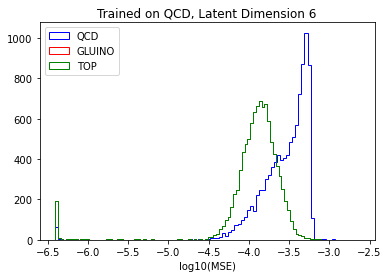

In [19]:
plt.title('Trained on QCD, Latent Dimension 6')
plt.xlabel("log10(MSE)")
plt.hist(np.log10(msebg),histtype='step',color='blue',bins=100,label='QCD')
plt.hist(np.log10(msesigGLU),histtype='step',color='red',bins=100,label='GLUINO')
plt.hist(np.log10(msesigTOP),histtype='step',color='green',bins=100,label='TOP')
plt.legend(loc='upper left')
plt.show()

In [20]:
outputtrain=autoencoder.predict(trainimages, batch_size=1024, verbose=0)
difftrain=trainimages-outputtrain
msetrain=((difftrain)**2).mean(axis=(1,2,3))

In [21]:
encodedtrain=encodedmodel.predict(trainimages, batch_size=1024, verbose=0)
latent_train = [encodedtrain[x].tolist() for x in range(Ntrain)]
for index in range(len(latent_train)):
    latent_train[index].insert(0,msetrain[index])
latenttrainarray=np.asarray(latent_train)
np.savetxt('AE_latent/train_latents-60.csv', latenttrainarray, delimiter = ',')
print("Train done.")

Train done.
